In [1]:
import matplotlib.pyplot as plt

In [2]:
import torch
from torch.autograd import Variable
import numpy as np
from sklearn.model_selection import train_test_split

import torch.nn as nn
from torchmoji.global_variables import PRETRAINED_PATH
import sys

sys.path.append('../')

from src.data import DataGenerator
from src import TRAIN_DATASET_PATH, VA_REGRESSION_WEIGHTS_PATH, PRETRAINED_VOCABULARY_SIZE
from src.models.attlayer import Attention
from src.models import *

from tqdm import tqdm
import pandas as pd

Torchmoji weights: /usr/local/lib/python3.6/dist-packages/model/pytorch_model.bin
Torchmoji vocabulary: /home/meme/meme/models/vocabulary.json
Image captioning weights: /home/meme/meme/models/captioning//BEST_checkpoint_coco_5_cap_per_img_5_min_word_freq.pth.tar
Image captioning word map: /home/meme/meme/models/captioning//WORDMAP_coco_5_cap_per_img_5_min_word_freq.json


[nltk_data] Downloading package wordnet to /home/meme/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
data = pd.read_csv(TRAIN_DATASET_PATH)
data = data.dropna()

model = TorchMoji()

/usr/local/lib/python3.6/dist-packages/torchmoji/model_def.py:159: UserWarning: nn.init.uniform is now deprecated in favor of nn.init.uniform_.
  nn.init.uniform(self.embed.weight.data, a=-0.5, b=0.5)
/usr/local/lib/python3.6/dist-packages/torchmoji/model_def.py:161: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(t)
/usr/local/lib/python3.6/dist-packages/torchmoji/model_def.py:163: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
  nn.init.orthogonal(t)
/usr/local/lib/python3.6/dist-packages/torchmoji/model_def.py:165: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  nn.init.constant(t, 0)
/usr/local/lib/python3.6/dist-packages/torchmoji/model_def.py:167: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(self.output_layer[0].weight.data)


In [5]:
data.head()

,Unnamed: 0,Tweet_id,Tweet,Unicode_emoji,Emoji,V,A
0,0,798577437726666752,so ready for thanksgiving \U0001f60a\U0001f60a...,\U0001f60a,😊,0.861667,0.576667
1,1,798577437726666752,so ready for thanksgiving \U0001f60a\U0001f60a...,\U0001f60a,😊,0.881667,0.613333
3,3,798577441916809216,Okay \U0001f634 https://t.co/JPCJl9gRX7,\U0001f634,😴,0.621667,0.200000
4,4,798577441916809216,Okay \U0001f634 https://t.co/JPCJl9gRX7,\U0001f634,😴,0.680000,0.188333
7,7,798577446102515712,@RowdyCowboyDC @wfaachannel8 @WFAAalexa You're...,\U0001f61c,😜,0.783333,0.583333


In [6]:
model.predict(data.Tweet[3])

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:91: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


['💓', '💪', '✌', '😄', '☺']

In [7]:
predictions = data.Tweet.apply(model.predict)

In [10]:
predictions_first = predictions.apply(lambda em_list: em_list[0])

In [11]:
(predictions_first == data.Emoji).astype(int).mean()

0.064112367690264419

In [12]:
indicator_top5 = []
for em_list, real_emoji in zip(predictions, data.Emoji):
    indicator_top5.append(real_emoji in em_list)
indicator_top5 = np.array(indicator_top5).astype(int)    

In [13]:
indicator_top5.mean()

0.20018513301404597

## Plots

In [14]:
data['top5_match'] = indicator_top5

In [16]:
data['Tweet_len'] = data.Tweet.apply(len)

In [71]:
lengths = data.groupby(by='Tweet_len').agg({'top5_match': [sum, len]}).reset_index()
lengths['accuracy'] = lengths['top5_match']['sum'] / lengths['top5_match']['len']
lengths.columns = ['Tweet_len', 'sum', 'len', 'accuracy']
lengths

,Tweet_len,sum,len,accuracy
0,14,2,6,0.333333
1,15,2,12,0.166667
2,16,4,12,0.333333
3,17,5,28,0.178571
4,18,4,14,0.285714
5,19,14,31,0.451613
6,20,18,48,0.375000
7,21,10,53,0.188679
8,22,10,58,0.172414
9,23,8,55,0.145455


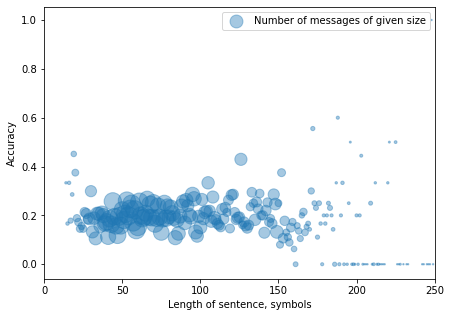

In [99]:
plt.figure(figsize = (7, 5))
plt.scatter(x=lengths.Tweet_len, y = lengths.accuracy, alpha=0.4, s=lengths.len, 
            label='Number of messages of given size')
plt.xlim(0, 250)
plt.xlabel('Length of sentence, symbols')
plt.ylabel('Accuracy')
plt.legend()

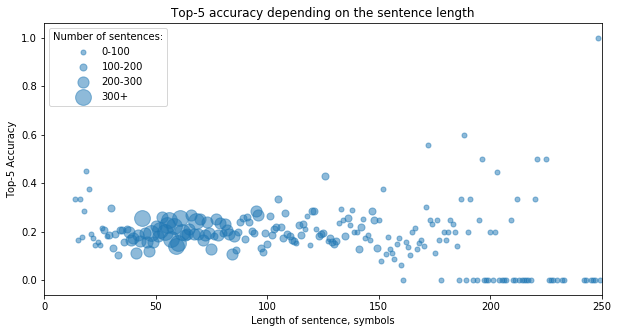

In [158]:
bins = np.arange(0, lengths.len.max(), 100)
grouped = lengths.groupby(np.digitize(lengths.len, bins))

# Create some sizes and some labels.
sizes = [25*(i**2+1.) for i in range(len(bins))]
labels = ['0-100', '100-200', '200-300', '300+']

plt.figure(figsize = (10, 5))
for i, (name, group) in enumerate(grouped):
    plt.scatter(group.Tweet_len, group.accuracy, s=sizes[i], alpha=0.5, label=labels[i], color='C0')

plt.xlim(0, 250)
plt.title('Top-5 accuracy depending on the sentence length')
plt.xlabel('Length of sentence, symbols')
plt.ylabel('Top-5 Accuracy')
plt.legend(title="Number of sentences:", loc='upper left')
plt.savefig('accuracy_length.png', dpi=300)

In [109]:
sizes

[50.0, 100.0, 150.0, 200.0, 250.0]